In [ ]:
#Machine Learning CS5262 Project
#Group: BioLearn
#Project Description:
#The goal of our project is to use unsupervised machine learning methods to identify populations
#of cells that are associated with COVID-19 disease status in order to predict COVID-19 infection.
#To address this question, we will use a mass cytometry dataset (Geanon et al., 2021) that
#describes protein expression on individual blood cells taken from either healthy controls or
#from patients hospitalized with COVID-19. We will be analyzing cells from 10 healthy patients
#and 36 patients that were hospitalized with severe COVID-19. Each cell has 42 protein expression
#features, and each disease group has millions of pooled cells.

#We will be comparing the cellular profiles between disease status groups to learn which cells
#are specific to COVID-19 patients. To do this, we will use dimensionality reduction and
#unsupervised clustering to divide the cells into subtypes based on their protein expression
#values, and then we will test if any subtype is enriched or depleted in the COVID-19 patients
#compared to the healthy controls. We will use a subset of the dataset to train our model to
#learn which cell types are associated with COVID-19, and then we will try to predict disease
#status in the testing set based on their cell subtype abundances using logistic regression. We
#also plan on testing different dimensionality reduction (tSNE and PCA) and clustering techniques
#(k-means and hierarchical clustering) to learn which combination will give the most accurate
#predictions.

#To divide the work, we will each focus on a different dimensionality reduction algorithm:
#Claire will use tSNE and Alexa will use PCA, and then we will each experiment with clustering
#techniques within our separate latent spaces to learn COVID-19 associated cell populations. We
#will then work together to create the logistic regression framework for the prediction component
#of the project. We plan to complete data preprocessing and background reading (see below) by
#2/15, learn the COVID-19 associated cell populations before spring break, and make disease
#status predictions after spring break. We will regularly update each other of our progress
#through text messaging or after class.

In [ ]:
#import modules
import os
import time
import random
import fcsparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import colorcet as cc
from sklearn.svm import SVC
import scipy.stats as stats
import time

In [ ]:
#define classes/functions
'''
Calculate model performance accuracy
@param y (np.ndarray) - actual classes for the data points
       pred_y (np.ndarray) - predicted classes for the data points
@return prediction accuracy (float)
'''
def evaluate(y, pred_y):
    accuracy = 0
    for i in range(len(pred_y)):
        if pred_y[i] == y[i]: #increase accuracy score if the predicted value of y is equal to the actual value of y
            accuracy += 1
        else:
            pass
    return accuracy*100/len(pred_y) #put on a 0-100% scale

In [ ]:
#load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

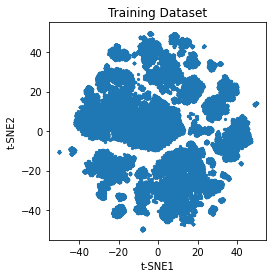

In [ ]:
#tSNE plot - all cells
fig, ax = plt.subplots()
plt.scatter(train_data.tSNE_1, train_data.tSNE_2, s=5)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.title('Training Dataset')
ax.set_aspect('equal')

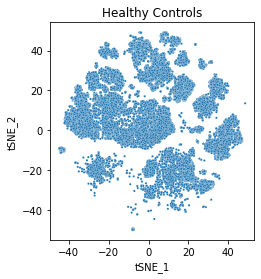

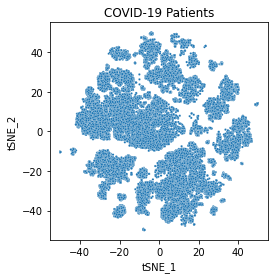

In [ ]:
#tSNE plot - disease status
#healthy cells
fig, ax = plt.subplots()
sns.scatterplot(data=train_data.loc[train_data['disease_status']==0],
                x='tSNE_1', y='tSNE_2', s=5, hue='disease_status')
plt.legend([],[], frameon=False)
plt.title('Healthy Controls')
ax.set_aspect('equal')
plt.show()

#COVID cells
fig, ax = plt.subplots()
sns.scatterplot(data=train_data.loc[train_data['disease_status']==1],
                x='tSNE_1', y='tSNE_2', s=5, hue='disease_status')
plt.legend([],[], frameon=False)
plt.title('COVID-19 Patients')
ax.set_aspect('equal')
plt.show()

In [ ]:
#select tSNE data and disease state for clustering
to_cluster = pd.concat([train_data.iloc[:,42:44], train_data.iloc[:,44:46]], axis=1)
to_cluster

,tSNE_1,tSNE_2,File_ID,disease_status
0,8.287571,31.955734,32,0
1,-22.570590,16.376387,32,0
2,-0.003941,43.652810,32,0
3,-5.118188,-3.609210,32,0
4,-37.341904,10.780662,32,0
...,...,...,...,...
208507,-7.713913,6.936693,12,1
208508,-15.162644,8.094783,30,1
208509,7.169008,-27.548850,10,1
208510,10.653549,-14.104429,4,1


In [ ]:
#k-means clustering with cross-validation on the training set
start_time = time.time()

clustered_data = to_cluster.copy()
different_cells = pd.DataFrame(columns=['k', 'different cells'])
for k in range(5, 66, 5): #test k values from 5 to 65, increasing by 5
    print(k)
    #perform k-means clustering
    km = KMeans(n_clusters=k)
    clustered_data['cluster'] = km.fit_predict(clustered_data.iloc[:,:2]) #perform clustering on t-SNE axes from training set

    #calculate what proportion of each cluster comes from healthy/covid patients
    group_abundances = np.zeros((2,k)) #first row stores healthy proportion, second row stores covid proportion
    difference = [] #will keep track of the difference in proportion between the two disease groups
    diff_cells = 0 #count how many cells are in clusters that are specific to one disease group

    #loop through each cluster
    for cluster in sorted(clustered_data['cluster'].unique()):
        cluster_count = (clustered_data['cluster'] == cluster).sum() #how many cells in this cluster

        #calculate what proportion of each cluster comes from healthy/covid patients
        healthy_percent = ((clustered_data['cluster']==cluster) & (clustered_data['disease_status'] == 0)).sum()/cluster_count*100
        covid_percent = ((clustered_data['cluster']==cluster) & (clustered_data['disease_status'] == 1)).sum()/cluster_count*100

        #first row stores healthy proportion, second row stores covid proportion
        group_abundances[0, cluster] = healthy_percent
        group_abundances[1, cluster] = covid_percent

        #calculate difference in proportion between the two groups
        r = abs(healthy_percent-covid_percent) #r = range
        difference.append(r)
        if r > 70: #difference of 70 = 85th percentile; a large difference between the two groups
            diff_cells = diff_cells + cluster_count
    #add to dataframe
    different_cells = pd.concat([different_cells, pd.DataFrame([[k, diff_cells]], columns=['k', 'different cells'])])
#re-index
df = different_cells.reset_index(drop=True)

#plot cross-validation results
fig, ax = plt.subplots()
g = sns.lineplot(data=df,
                    x='k', y='different cells')
plt.title('k-means cross validation')
plt.show()

#determine how stable each k is (does it change a lot jumping to the previous or next k value?)
avg_change = 0
stability = pd.DataFrame(columns=['k', 'average change'])
for i in range(1, (len(different_cells)-1)):
    avg_change = (abs(df.iloc[i,1]-df.iloc[i-1,1]) + abs(df.iloc[i,1]-df.iloc[i+1,1]))/2
    stability = pd.concat([stability, pd.DataFrame([[df.iloc[i,0], avg_change]], columns=['k', 'average change'])])

print(stability.loc[(stability['average change'] == stability['average change'].min()), :])

total_time = time.time()-start_time
print('total time: ', total_time)

In [ ]:
#set the optimal k value determined above
optimized_k = 50

In [ ]:
#combine training and testing set for clustering (will split back out to perform classification)
split_ind = len(train_data) #this index will be used to split back into training and testing sets after clustering
final_clustering = pd.concat([train_data.iloc[:,42:46], test_data.iloc[:,42:46]])
final_clustering = final_clustering.reset_index(drop=True)
final_clustering

,tSNE_1,tSNE_2,File_ID,disease_status
0,8.287571,31.955734,32,0
1,-22.570590,16.376387,32,0
2,-0.003941,43.652810,32,0
3,-5.118188,-3.609210,32,0
4,-37.341904,10.780662,32,0
...,...,...,...,...
255235,-28.321657,28.552776,27,1
255236,13.718305,-35.034157,27,1
255237,27.050547,32.026070,26,1
255238,12.609589,-27.151040,16,1


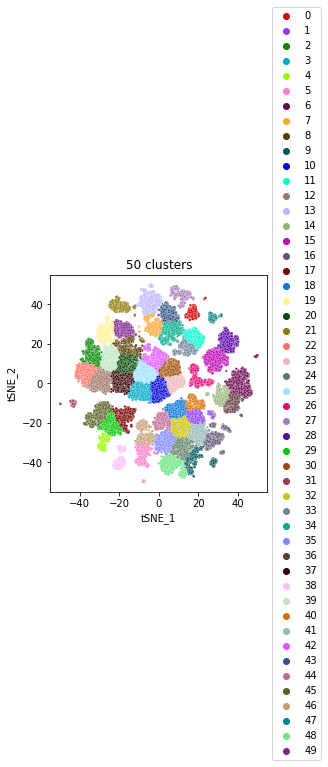

In [ ]:
#final patient classification
km = KMeans(n_clusters=optimized_k)
final_clustering['cluster'] = km.fit_predict(final_clustering.iloc[:,:2]) #perform clustering on training and validation sets

#plot clusters
palette = sns.color_palette(cc.glasbey, n_colors=optimized_k) #set color palette

fig, ax = plt.subplots()
g = sns.scatterplot(data=final_clustering,
                    x='tSNE_1', y='tSNE_2',
                    s=5, hue='cluster',
                    legend='full', palette=palette)
plt.title(str(optimized_k) + ' clusters')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.set_aspect('equal')
plt.show()

clustered_train_data = final_clustering.iloc[:split_ind,:]
clustered_test_data = final_clustering.iloc[split_ind:,:]

interesting clusters: [4, 5, 9, 17, 18, 23, 24, 35, 38, 40, 45, 46, 48]


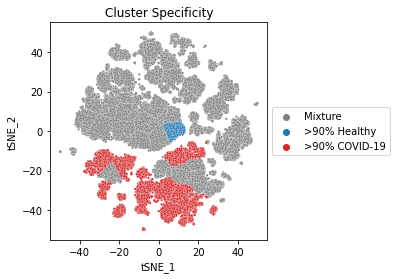

In [ ]:
#disease-specific population plot
clust_spec = pd.DataFrame(columns=['cluster', 'specificity'])

#calculate what proportion of each cluster comes from healthy/covid patients
group_abundances = np.zeros((2,optimized_k)) #first row stores healthy proportion, second row stores covid proportion
difference = [] #will keep track of the difference in proportion between the two disease groups
diff_cells = 0 #count how many cells are in clusters that are specific to one disease group

#loop through each cluster
for cluster in sorted(final_clustering['cluster'].unique()):
    cluster_count = (final_clustering['cluster'] == cluster).sum() #how many cells in this cluster

    #calculate what proportion of each cluster comes from healthy/covid patients
    healthy_percent = ((final_clustering['cluster']==cluster) & (final_clustering['disease_status'] == 0)).sum()/cluster_count*100
    covid_percent = ((final_clustering['cluster']==cluster) & (final_clustering['disease_status'] == 1)).sum()/cluster_count*100

    #first row stores healthy proportion, second row stores covid proportion
    group_abundances[0, cluster] = healthy_percent
    group_abundances[1, cluster] = covid_percent

    #calculate difference in proportion between the two groups
    r = healthy_percent-covid_percent #r = range
    difference.append(r)
    if r > 80: #difference of 80 = 90th percentile for healthy
        clust_spec = pd.concat([clust_spec, pd.DataFrame([[cluster, '>90% Healthy']], columns=['cluster', 'specificity'])])
    elif r < -80: #difference of 80 = 90th percentilefor covid
        clust_spec = pd.concat([clust_spec, pd.DataFrame([[cluster, '>90% COVID-19']], columns=['cluster', 'specificity'])])
    else:
        clust_spec = pd.concat([clust_spec, pd.DataFrame([[cluster, 'Mixture']], columns=['cluster', 'specificity'])])

combo = final_clustering.merge(clust_spec, on='cluster')

#print interesting cluster numbers
not_mixture = combo.loc[combo['specificity'] != 'Mixture']
interesting_clusters = not_mixture['cluster'].unique()
print('interesting clusters:', sorted(interesting_clusters))

# cluster specific plot
pal = {'>90% Healthy':"tab:blue",
       '>90% COVID-19':"tab:red",
       'Mixture':"tab:gray"}

fig, ax = plt.subplots()
g = sns.scatterplot(data=combo,
                    x='tSNE_1', y='tSNE_2',
                    s=5, hue='specificity',
                    legend='full', palette=pal) #set color palette) #set color palette)
plt.title('Cluster Specificity')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.set_aspect('equal')
plt.show()

In [ ]:
#describe COVID-19 specific populations

#combine cluster data with expression data
all_train_data = train_data.merge(clustered_train_data, on=['tSNE_1', 'tSNE_2', 'File_ID', 'disease_status'])
all_test_data = test_data.merge(clustered_test_data, on=['tSNE_1', 'tSNE_2', 'File_ID', 'disease_status'])
all_data = pd.concat([all_train_data, all_test_data]).reset_index(drop=True)

#get median of each column
medians = all_data.median(axis=0)

#find interesting cluster markers that are greater than the median
threshold = 1.5
d = {} #dictionary to store enriched markers
#loop through each interesting cluster
for clust in sorted(interesting_clusters):
    #print(clust)
    d[clust] = []
    clust_data = all_data.loc[all_data['cluster'] == clust]
    clust_medians = clust_data.median(axis=0)
    clust_cell_count = len(clust_data)

    #loop through each marker
    for name, val in clust_medians[:-5].iteritems():
        diff = clust_medians[name] - medians[name]
        if diff >= threshold:
            #print(name, 'is enriched on cluster', clust)
            d[clust].append(name)
        #elif diff <= -threshold:
            #print(name, 'is lacking on cluster', clust)

#report
for key in d.keys():
    if '170Er_CD3' in d[key]:
        print('cluster', key, 'contains', len(all_data.loc[all_data['cluster'] == key]), 'T cells')
    if '172Yb_CD66b' in d[key]:
        print('cluster', key, 'contains', len(all_data.loc[all_data['cluster'] == key]), 'neutrophils')
    if '171Yb_CD20' in d[key]:
        print('cluster', key, 'contains', len(all_data.loc[all_data['cluster'] == key]), 'B cells')
    if '168Er_CD14' in d[key]:
        print('cluster', key, 'contains', len(all_data.loc[all_data['cluster'] == key]), 'monocytes')
    if '163Dy_CD56' in d[key]:
        print('cluster', key, 'contains', len(all_data.loc[all_data['cluster'] == key]), 'NK cells')


cluster 4 contains 2085 neutrophils
cluster 5 contains 3562 monocytes
cluster 9 contains 3170 monocytes
cluster 17 contains 4103 neutrophils
cluster 18 contains 4064 monocytes
cluster 23 contains 8445 T cells
cluster 24 contains 3376 monocytes
cluster 35 contains 4253 monocytes
cluster 38 contains 2835 neutrophils
cluster 40 contains 2402 monocytes
cluster 45 contains 5161 neutrophils
cluster 46 contains 3860 monocytes
cluster 48 contains 4675 monocytes


In [ ]:
len(clust_data)

4675

In [ ]:
key

48

In [ ]:
#get cluster abundance for each training set patient
file_list = []
train_cluster_abundance = np.zeros((len(clustered_train_data['File_ID'].unique()),optimized_k))
sample_count = 0
for file in sorted(clustered_train_data['File_ID'].unique()):
    if file < 31: #covid
        file_list.append(1)
    else: #healthy
        file_list.append(0)
    sample_cell_count = (clustered_train_data['File_ID'] == file).sum() #calculate the total number of cells from this sample
    cluster_count = 0
    for cluster in sorted(clustered_train_data['cluster'].unique()):
        cluster_cell_count = ((clustered_train_data['File_ID']==file) & (clustered_train_data['cluster']==cluster)).sum()
        percent = cluster_cell_count/sample_cell_count*100
        train_cluster_abundance[sample_count,cluster_count] = percent
        cluster_count += 1
    sample_count += 1
train_targets = np.array(file_list) #0 = healthy, 1=covid


#get cluster abundance for each test set patient
file_list = []
sample_count = 0
test_cluster_abundance = np.zeros((len(clustered_test_data['File_ID'].unique()),optimized_k))
for file in sorted(clustered_test_data['File_ID'].unique()):
    if file < 31: #covid
        file_list.append(1)
    else: #healthy
        file_list.append(0)
    sample_cell_count = (clustered_test_data['File_ID'] == file).sum() #calculate the total number of cells from this sample
    cluster_count = 0
    for cluster in sorted(clustered_test_data['cluster'].unique()):
        cluster_cell_count = ((clustered_test_data['File_ID']==file) & (clustered_test_data['cluster']==cluster)).sum()
        percent = cluster_cell_count/sample_cell_count*100
        test_cluster_abundance[sample_count,cluster_count] = percent
        cluster_count += 1
    sample_count += 1
test_targets = np.array(file_list) #0 = healthy, 1=covid



#split features and targets
train_x = train_cluster_abundance
train_y = train_targets
test_x = test_cluster_abundance
test_y = test_targets

#determine classification accuracy with SVM
model = SVC(C=1, gamma=1, kernel='rbf')
model.fit(train_x, train_y)
train_acc = evaluate(train_y, model.predict(train_x))
test_acc = evaluate(test_y, model.predict(test_x))

print('training accuracy: ', train_acc)
print('test accuracy: ', test_acc)

training accuracy:  100.0
test accuracy:  75.0


In [ ]:
#check if model is predicting any healthies
model.predict(test_x)

array([1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
interesting_clusters

array([22, 40, 32, 0, 46, 42, 19, 33, 49, 14, 20, 31, 13], dtype=object)

In [ ]:
#feature selection - just interesting clusters
selected_train_x = np.zeros((len(clustered_train_data['File_ID'].unique()), len(interesting_clusters)))
selected_test_x = np.zeros((len(clustered_test_data['File_ID'].unique()), len(interesting_clusters)))

#train data
count = 0
for clust in range(50):
    if clust in interesting_clusters: #add that cluster's column to feature selected dataframe
        selected_train_x[:, count] = train_cluster_abundance[:,clust]
        selected_test_x[:, count] = test_cluster_abundance[:,clust]
        count += 0

#determine classification accuracy with SVM
model2 = SVC(C=1, gamma=1, kernel='rbf')
model2.fit(selected_train_x, train_y)
train_acc = evaluate(train_y, model2.predict(selected_train_x))
test_acc = evaluate(test_y, model2.predict(selected_test_x))

print('training accuracy: ', train_acc)
print('test accuracy: ', test_acc)

training accuracy:  70.58823529411765
test accuracy:  75.0


In [ ]:
#check if model is predicting any healthies
model2.predict(selected_test_x)

array([1, 1, 1, 1, 1, 1, 1, 1])